Image Classifier with pyreason
Using a modified image classifier from this tutorial: https://www.youtube.com/watch?v=igQeI29FIQM
This creates a CNN using the CIFAR10 Dataset used to classify images into ten different subclasses

Import dependencies

In [3]:
%pip install torch torchvision torchsummary numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Import libraries

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

Use GPU instead of CPU if you can

In [34]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


Download the dataset, transform image data to tensors and normalize the tensors

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

AttributeError: 'DataLoader' object has no attribute 'to'

In [8]:
print('Number of images in the training dataset:', len(train_set))
print('Number of images in the testing dataset:', len(test_set))
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Number of images in the training dataset: 50000
Number of images in the testing dataset: 10000
Shape of the images in the training dataset: torch.Size([3, 32, 32])


Print the first 10 images in the dataset

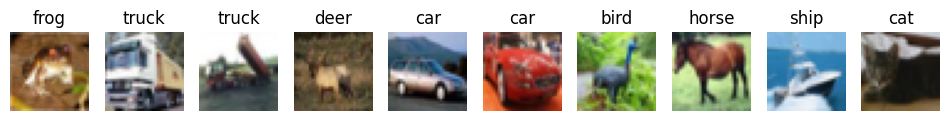

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()

Create a convolutional neural network to classify images.  We use two convolution layers, a max pooling layer, and 3 fully connected layers.

In [36]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


net = ConvNeuralNet()
net.to(device)

ConvNeuralNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
summary(net.to(device), (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3          [-1, 128, 13, 13]          73,856
         MaxPool2d-4            [-1, 128, 6, 6]               0
            Linear-5                  [-1, 120]         553,080
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 639,742
Trainable params: 639,742
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 2.44
Estimated Total Size (MB): 3.20
----------------------------------------------------------------


Run training

In [37]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1/10,  2000] loss: 1.757
[1/10,  4000] loss: 1.473
[1/10,  6000] loss: 1.353
[1/10,  8000] loss: 1.291
[1/10, 10000] loss: 1.219
[1/10, 12000] loss: 1.178
[2/10,  2000] loss: 1.093
[2/10,  4000] loss: 1.068
[2/10,  6000] loss: 1.073
[2/10,  8000] loss: 1.044
[2/10, 10000] loss: 1.022
[2/10, 12000] loss: 1.018
[3/10,  2000] loss: 0.904
[3/10,  4000] loss: 0.969
[3/10,  6000] loss: 0.930
[3/10,  8000] loss: 0.941
[3/10, 10000] loss: 0.911
[3/10, 12000] loss: 0.926
[4/10,  2000] loss: 0.831
[4/10,  4000] loss: 0.838
[4/10,  6000] loss: 0.845
[4/10,  8000] loss: 0.825
[4/10, 10000] loss: 0.881
[4/10, 12000] loss: 0.871
[5/10,  2000] loss: 0.766
[5/10,  4000] loss: 0.784
[5/10,  6000] loss: 0.792
[5/10,  8000] loss: 0.782
[5/10, 10000] loss: 0.819
[5/10, 12000] loss: 0.803
[6/10,  2000] loss: 0.710
[6/10,  4000] loss: 0.732
[6/10,  6000] loss: 0.754
[6/10,  8000] loss: 0.762
[6/10, 10000] loss: 0.770
[6/10, 12000] loss: 0.779
[7/10,  2000] loss: 0.679
[7/10,  4000] loss: 0.699
[7/10,  6000

View image classification

In [39]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

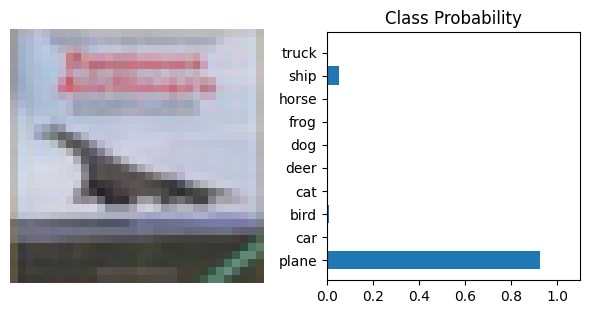

In [60]:
images, _ = next(iter(test_loader))

image = images[3]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image, probabilities)

View accuracy

In [48]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


Now, we will use pyreason to make infrences from our CNN

In [49]:
import pyreason as pr
import networkx as nx

In [50]:
# Define integration options.
# Only probabilities above 0.5 are considered for adjustment.
interface_options = pr.ModelInterfaceOptions(
    threshold=0.5,       # Only process probabilities above 0.5
    set_lower_bound=True,  # For high confidence, adjust the lower bound.
    set_upper_bound=False, # Keep the upper bound unchanged.
    snap_value=1.0      # Use 1.0 as the snap value.
)

In [51]:
# Wrap the model using LogicIntegratedClassifier
image_classifier = pr.LogicIntegratedClassifier(
    net,
    classes,
    model_name="image_classifier",
    interface_options=interface_options
)

In [63]:
image = train_loader.dataset[i][0].to(device)  # Move the image to the same device as the model
logits, probabilities, classifier_facts = image_classifier(image)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (128x36 and 4608x120)